## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [9]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [10]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [11]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [12]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [13]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [14]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [15]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [16]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day', 'temp_initial00'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/direct_model_train_pb_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [17]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [18]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [19]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [20]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [21]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [22]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [23]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [24]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [25]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [26]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0771661
RMSE of after m0 0.24895063
RMSE of after m0 0.089507304
RMSE of after m0 0.14248642
RMSE of after m0 0.01820331
RMSE of after m0 0.013313463
RMSE of after m0 0.0087977005
RMSE of after m0 0.008811412
RMSE of after m0 0.01107982
RMSE of after m0 0.010878513
RMSE of after m0 0.009298528
RMSE of after m0 0.013368238
RMSE of after m0 0.011603065
RMSE of after m0 0.011497208
RMSE of after m0 0.035607837
RMSE of after m0 0.037117288
RMSE of after m0 0.030203486
RMSE of after m0 0.020617822
RMSE of after m0 0.019854419
RMSE of after m0 0.016890913
RMSE of after m0 0.018503623
RMSE of after m0 0.027579037
RMSE of after m0 0.021931497
RMSE of after m0 0.030091053
RMSE of after m0 0.018060671
RMSE of after m0 0.013982979
RMSE of after m0 0.023761418
RMSE of after m0 0.013032203
RMSE of after m0 0.0181701
RMSE of after m0 0.014247098
RMSE of after m0 0.021133067
RMSE of after m0 0.02275569
RMSE of after m0 0.022810102
RMSE of after m0 0.019711355
RMSE of after m0 0.021

RMSE of after m0 0.04794505
RMSE of after m0 0.059938315
RMSE of after m0 0.03885367
RMSE of after m0 0.037771165
RMSE of after m0 0.031752773
RMSE of after m0 0.02809885
RMSE of after m0 0.026903775
RMSE of after m0 0.031215781
RMSE of after m0 0.048299737
RMSE of after m0 0.04348383
RMSE of after m0 0.037737314
RMSE of after m0 0.061959628
RMSE of after m0 0.03149115
RMSE of after m0 0.028840654
RMSE of after m0 0.044774286
RMSE of after m0 0.021212438
RMSE of after m0 0.023953862
RMSE of after m0 0.034354392
RMSE of after m0 0.019227048
RMSE of after m0 0.02079633
RMSE of after m0 0.020508703
RMSE of after m0 0.01565467
RMSE of after m0 0.019467155
RMSE of after m0 0.015138399
RMSE of after m0 0.019492261
RMSE of after m0 0.016998641
RMSE of after m0 0.015775029
RMSE of after m0 0.014248512
RMSE of after m0 0.019503992
RMSE of after m0 0.04116011
RMSE of after m0 0.03939657
RMSE of after m0 0.102313876
RMSE of after m0 0.044761613
RMSE of after m0 0.043227397
RMSE of after m0 0.2361

RMSE of after m0 0.07874688
RMSE of after m0 0.06691952
RMSE of after m0 0.043689515
RMSE of after m0 0.023716068
RMSE of after m0 0.0368494
RMSE of after m0 0.059051376
RMSE of after m0 0.030675037
RMSE of after m0 0.020717718
RMSE of after m0 0.019741146
RMSE of after m0 0.030156292
RMSE of after m0 0.04424947
RMSE of after m0 0.029706938
RMSE of after m0 0.06703849
RMSE of after m0 0.0878618
RMSE of after m0 0.06270249
RMSE of after m0 0.06627603
RMSE of after m0 0.042579226
RMSE of after m0 0.050127156
RMSE of after m0 0.028674062
RMSE of after m0 0.032820277
RMSE of after m0 0.03964614
RMSE of after m0 0.036903087
RMSE of after m0 0.030366905
RMSE of after m0 0.026496511
RMSE of after m0 0.024276558
RMSE of after m0 0.04975141
RMSE of after m0 0.048826214
RMSE of after m0 0.032152425
RMSE of after m0 0.035093572
RMSE of after m0 0.049591314
RMSE of after m0 0.04497566
RMSE of after m0 0.03913408
RMSE of after m0 0.03690002
RMSE of after m0 0.044156935
RMSE of after m0 0.039333694


RMSE of after m0 0.01589505
RMSE of after m0 0.015126385
RMSE of after m0 0.016767187
RMSE of after m0 0.017380467
RMSE of after m0 0.017412016
RMSE of after m0 0.018995618
RMSE of after m0 0.020521939
RMSE of after m0 0.022207923
RMSE of after m0 0.018883301
RMSE of after m0 0.03274353
RMSE of after m0 0.032315757
RMSE of after m0 0.023013633
RMSE of after m0 0.0229575
RMSE of after m0 0.021121513
RMSE of after m0 0.023022557
RMSE of after m0 0.02154837
RMSE of after m0 0.010560664
RMSE of after m0 0.0098976875
RMSE of after m0 0.011534445
RMSE of after m0 0.01148462
RMSE of after m0 0.021708319
RMSE of after m0 0.01377343
RMSE of after m0 0.01633064
RMSE of after m0 0.017925711
RMSE of after m0 0.017679298
RMSE of after m0 0.01592591
RMSE of after m0 0.015358974
RMSE of after m0 0.014994996
RMSE of after m0 0.046376422
RMSE of after m0 0.030918237
RMSE of after m0 0.019290164
RMSE of after m0 0.017351441
RMSE of after m0 0.015979484
RMSE of after m0 0.021676123
RMSE of after m0 0.018

RMSE of after m0 0.026073612
RMSE of after m0 0.023418741
RMSE of after m0 0.02152576
RMSE of after m0 0.023425767
RMSE of after m0 0.022370845
RMSE of after m0 0.02082164
RMSE of after m0 0.021795137
RMSE of after m0 0.03027391
RMSE of after m0 0.04061325
RMSE of after m0 0.030718347
RMSE of after m0 0.026399184
RMSE of after m0 0.048677027
RMSE of after m0 0.060229212
RMSE of after m0 0.03784961
RMSE of after m0 0.021519305
RMSE of after m0 0.019328134
RMSE of after m0 0.021264713
RMSE of after m0 0.022637008
RMSE of after m0 0.023451352
RMSE of after m0 0.019069664
RMSE of after m0 0.028705707
RMSE of after m0 0.051632974
RMSE of after m0 0.14386496
RMSE of after m0 0.07486163
RMSE of after m0 0.032356758
RMSE of after m0 0.10641684
RMSE of after m0 0.032542337
RMSE of after m0 0.014577628
RMSE of after m0 0.0313339
RMSE of after m0 0.03978096
RMSE of after m0 0.019162545
RMSE of after m0 0.033470307
RMSE of after m0 0.025335949
RMSE of after m0 0.019508503
RMSE of after m0 0.016936

RMSE of after m0 0.028634056
RMSE of after m0 0.03409921
RMSE of after m0 0.035848696
RMSE of after m0 0.051712234
RMSE of after m0 0.052093446
RMSE of after m0 0.030506456
RMSE of after m0 0.031155052
RMSE of after m0 0.043548092
RMSE of after m0 0.05143792
RMSE of after m0 0.040156655
RMSE of after m0 0.0412998
RMSE of after m0 0.048429187
RMSE of after m0 0.04402139
RMSE of after m0 0.03511194
RMSE of after m0 0.051976178
RMSE of after m0 0.03796732
RMSE of after m0 0.093284585
RMSE of after m0 0.05669413
RMSE of after m0 0.037135195
RMSE of after m0 0.042189244
RMSE of after m0 0.039934542
RMSE of after m0 0.043093402
RMSE of after m0 0.043141954
RMSE of after m0 0.034146443
RMSE of after m0 0.03436087
RMSE of after m0 0.035494525
RMSE of after m0 0.04668908
RMSE of after m0 0.040865466
RMSE of after m0 0.043974273
RMSE of after m0 0.038028173
RMSE of after m0 0.03529387
RMSE of after m0 0.042653844
RMSE of after m0 0.06201214
RMSE of after m0 0.07594982
RMSE of after m0 0.05399203

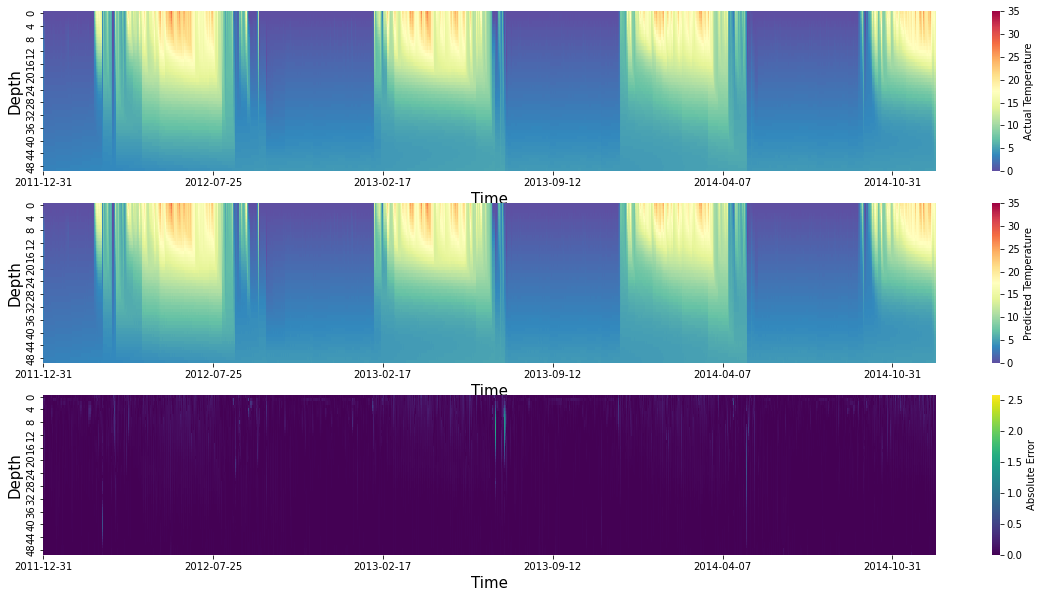

In [27]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

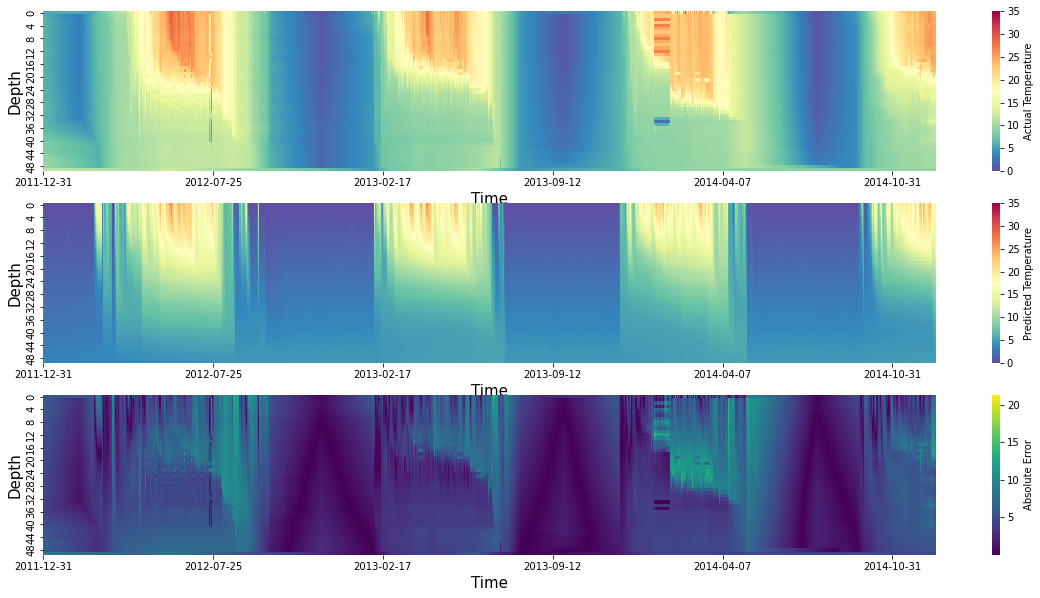

In [28]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [29]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.03885577
RMSE of after m0 0.056742877
RMSE of after m0 0.051499303
RMSE of after m0 0.04291746
RMSE of after m0 0.042545635
RMSE of after m0 0.04446697
RMSE of after m0 0.043656975
RMSE of after m0 0.04016462
RMSE of after m0 0.040501058
RMSE of after m0 0.05105792
RMSE of after m0 0.04279092
RMSE of after m0 0.043503232
RMSE of after m0 0.056032006
RMSE of after m0 0.048983514
RMSE of after m0 0.04853627
RMSE of after m0 0.07331778
RMSE of after m0 0.11506193
RMSE of after m0 0.0598761
RMSE of after m0 0.07569506
RMSE of after m0 0.08950982
RMSE of after m0 0.07538368
RMSE of after m0 0.060381737
RMSE of after m0 0.053036507
RMSE of after m0 0.03897003
RMSE of after m0 0.026920816
RMSE of after m0 0.030623395
RMSE of after m0 0.028288612
RMSE of after m0 0.045315035
RMSE of after m0 0.0318678
RMSE of after m0 0.032358274
RMSE of after m0 0.04903093
RMSE of after m0 0.06678286
RMSE of after m0 0.0484553
RMSE of after m0 0.057550862
RMSE of after m0 0.047447458
RMSE o

RMSE of after m0 0.015430572
RMSE of after m0 0.024173522
RMSE of after m0 0.009624158
RMSE of after m0 0.041030925
RMSE of after m0 0.02265019
RMSE of after m0 0.03799239
RMSE of after m0 0.026717084
RMSE of after m0 0.032802563
RMSE of after m0 0.054313168
RMSE of after m0 0.04836738
RMSE of after m0 0.03235875
RMSE of after m0 0.013480437
RMSE of after m0 0.018691884
RMSE of after m0 0.023023726
RMSE of after m0 0.0296579
RMSE of after m0 0.039466962
RMSE of after m0 0.03341032
RMSE of after m0 0.028718019
RMSE of after m0 0.075168006
RMSE of after m0 0.036156956
RMSE of after m0 0.021802388
RMSE of after m0 0.024773663
RMSE of after m0 0.052387178
RMSE of after m0 0.025397813
RMSE of after m0 0.02056054
RMSE of after m0 0.021948352
RMSE of after m0 0.023594184
RMSE of after m0 0.029626576
RMSE of after m0 0.015939478
RMSE of after m0 0.029384254
RMSE of after m0 0.04102206
RMSE of after m0 0.023423027
RMSE of after m0 0.056901593
RMSE of after m0 0.045326956
RMSE of after m0 0.0294

RMSE of after m0 0.013696424
RMSE of after m0 0.007897711
RMSE of after m0 0.008481187
RMSE of after m0 0.010175294
RMSE of after m0 0.011464385
RMSE of after m0 0.008272741
RMSE of after m0 0.015848909
RMSE of after m0 0.02851715
RMSE of after m0 0.012120617
RMSE of after m0 0.007535279
RMSE of after m0 0.013740001
RMSE of after m0 0.040206194
RMSE of after m0 0.041427217
RMSE of after m0 0.044756748
RMSE of after m0 0.015345975
RMSE of after m0 0.010776663
RMSE of after m0 0.010109709
RMSE of after m0 0.008192905
RMSE of after m0 0.012654531
RMSE of after m0 0.013844566
RMSE of after m0 0.034823697
RMSE of after m0 0.0388021
RMSE of after m0 0.015484582
RMSE of after m0 0.013119606
RMSE of after m0 0.014152086
RMSE of after m0 0.023535013
RMSE of after m0 0.009780369
RMSE of after m0 0.011557296
RMSE of after m0 0.010846822
RMSE of after m0 0.010690539
RMSE of after m0 0.012748054
RMSE of after m0 0.060399476
RMSE of after m0 0.016893094
RMSE of after m0 0.010490793
RMSE of after m0 

RMSE of after m0 0.036211345
RMSE of after m0 0.04746188
RMSE of after m0 0.03987346
RMSE of after m0 0.064991646
RMSE of after m0 0.06290349
RMSE of after m0 0.034594662
RMSE of after m0 0.042619124
RMSE of after m0 0.047580007
RMSE of after m0 0.059006296
RMSE of after m0 0.078872025
RMSE of after m0 0.04718121
RMSE of after m0 0.044863272
RMSE of after m0 0.05098974
RMSE of after m0 0.10153255
RMSE of after m0 0.055048592
RMSE of after m0 0.035261307
RMSE of after m0 0.04188061
RMSE of after m0 0.030878853
RMSE of after m0 0.03524198
RMSE of after m0 0.05137366
RMSE of after m0 0.040632438
RMSE of after m0 0.038465288
RMSE of after m0 0.02803996
RMSE of after m0 0.025684418
RMSE of after m0 0.026510226
RMSE of after m0 0.044852566
RMSE of after m0 0.036410462
RMSE of after m0 0.0444993
RMSE of after m0 0.0590502
RMSE of after m0 0.0347151
RMSE of after m0 0.038023055
RMSE of after m0 0.04028079
RMSE of after m0 0.048174992
RMSE of after m0 0.063702844
RMSE of after m0 0.05175876
RMS

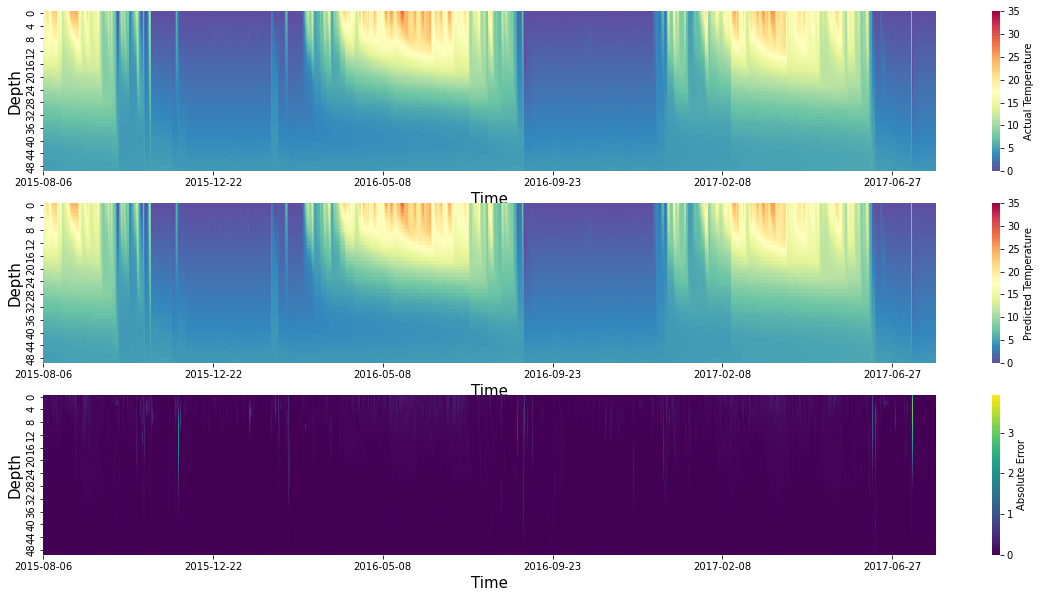

In [30]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

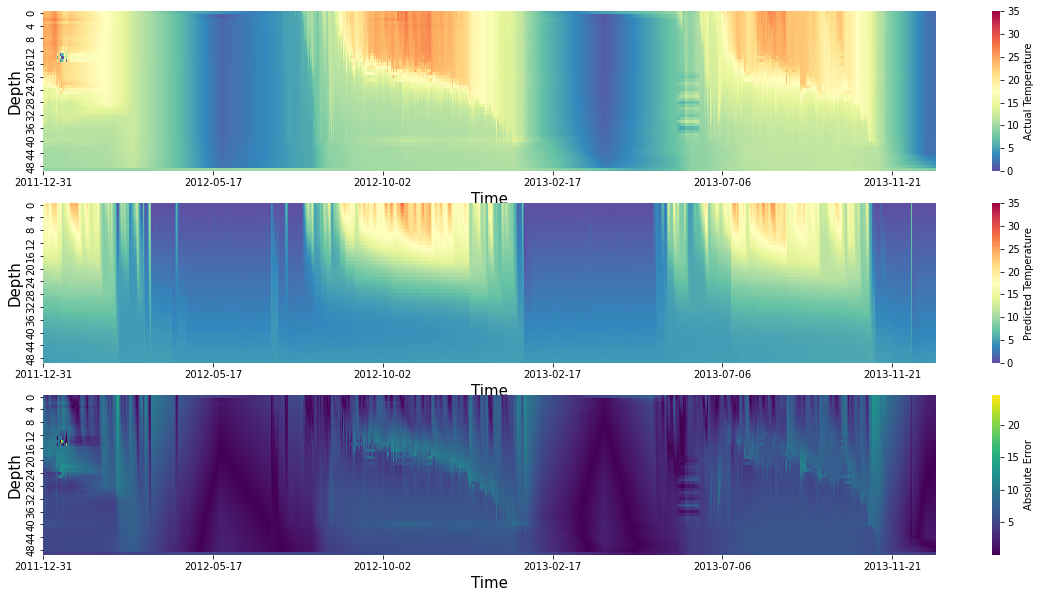

In [31]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [32]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.046175141791731975, Train L2 Error: 0.006080920258186743
Test RMSE: 0.06804321214432899, Train L2 Error: 0.008554532290753099


## Mixing Model

## Convection Model

## Ice Model

# Finetuning

In [33]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(direct_model.parameters()) 
optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [34]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [35]:
#freeze_model(heating_model)

unfreeze_model(direct_model)


# Finetuning on Observed Temperature

In [36]:
direct_model.train()


n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out0 = torch.tensor(train_mean[m0_output_column_ix[0]]).float().to(device)
std_out0 = torch.tensor(train_std[m0_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input

train_loss = []
LOSS_m0 = []


for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0

    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out0)/std_out0
        
        loss_m0 = criterion(m0_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m0
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()

    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)

    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:19<5:24:58, 19.52s/it]

Epoch : 0, Train_loss: 0.6577423023466016, Loss m0: 0.6577423023466016


  5%|▌         | 51/1000 [16:13<4:57:21, 18.80s/it]

Epoch : 50, Train_loss: 0.1287930559860342, Loss m0: 0.1287930559860342


 10%|█         | 101/1000 [31:52<4:38:37, 18.60s/it]

Epoch : 100, Train_loss: 0.10646013931872345, Loss m0: 0.10646013931872345


 15%|█▌        | 151/1000 [47:22<4:21:36, 18.49s/it]

Epoch : 150, Train_loss: 0.09486372513266891, Loss m0: 0.09486372513266891


 20%|██        | 201/1000 [1:02:49<4:06:53, 18.54s/it]

Epoch : 200, Train_loss: 0.08714763393979141, Loss m0: 0.08714763393979141


 25%|██▌       | 251/1000 [1:18:15<3:51:13, 18.52s/it]

Epoch : 250, Train_loss: 0.08253081431624176, Loss m0: 0.08253081431624176


 30%|███       | 301/1000 [1:33:45<3:38:00, 18.71s/it]

Epoch : 300, Train_loss: 0.07909587591119861, Loss m0: 0.07909587591119861


 35%|███▌      | 351/1000 [1:49:28<3:23:14, 18.79s/it]

Epoch : 350, Train_loss: 0.07605766843773037, Loss m0: 0.07605766843773037


 40%|████      | 401/1000 [2:04:55<3:04:20, 18.46s/it]

Epoch : 400, Train_loss: 0.07344211693643622, Loss m0: 0.07344211693643622


 45%|████▌     | 451/1000 [2:20:22<2:49:35, 18.53s/it]

Epoch : 450, Train_loss: 0.07121590629464349, Loss m0: 0.07121590629464349


 50%|█████     | 501/1000 [2:35:50<2:33:42, 18.48s/it]

Epoch : 500, Train_loss: 0.06909424118421434, Loss m0: 0.06909424118421434


 55%|█████▌    | 551/1000 [2:51:13<2:18:09, 18.46s/it]

Epoch : 550, Train_loss: 0.06718021117840423, Loss m0: 0.06718021117840423


 60%|██████    | 601/1000 [3:06:36<2:02:26, 18.41s/it]

Epoch : 600, Train_loss: 0.06562196189283567, Loss m0: 0.06562196189283567


 65%|██████▌   | 651/1000 [3:21:58<1:47:03, 18.40s/it]

Epoch : 650, Train_loss: 0.06430100183314272, Loss m0: 0.06430100183314272


 70%|███████   | 701/1000 [3:37:25<1:31:55, 18.45s/it]

Epoch : 700, Train_loss: 0.06307801172829702, Loss m0: 0.06307801172829702


 75%|███████▌  | 751/1000 [3:52:51<1:16:49, 18.51s/it]

Epoch : 750, Train_loss: 0.06166470832531801, Loss m0: 0.06166470832531801


 80%|████████  | 801/1000 [4:08:19<1:01:31, 18.55s/it]

Epoch : 800, Train_loss: 0.06037958425703412, Loss m0: 0.06037958425703412


 85%|████████▌ | 851/1000 [4:23:41<45:55, 18.49s/it]  

Epoch : 850, Train_loss: 0.059181026614867786, Loss m0: 0.059181026614867786


 90%|█████████ | 901/1000 [4:39:00<30:38, 18.57s/it]

Epoch : 900, Train_loss: 0.05790188705462476, Loss m0: 0.05790188705462476


 95%|█████████▌| 951/1000 [4:54:38<15:25, 18.89s/it]

Epoch : 950, Train_loss: 0.05689519736288748, Loss m0: 0.05689519736288748


100%|██████████| 1000/1000 [5:09:46<00:00, 18.59s/it]


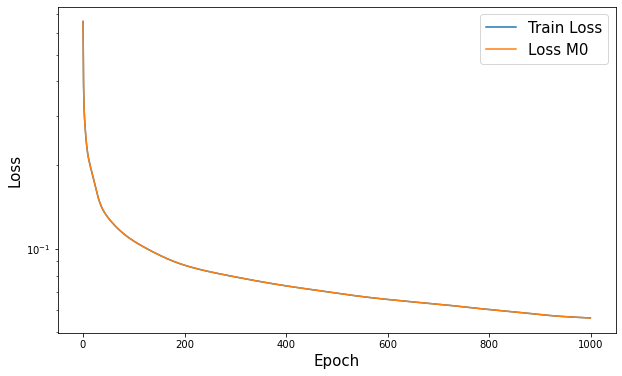

In [37]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")

plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [38]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 4.09131
RMSE of after m0 4.112106
RMSE of after m0 4.8348455
RMSE of after m0 4.5251412
RMSE of after m0 4.5126762
RMSE of after m0 4.6545553
RMSE of after m0 4.6788473
RMSE of after m0 4.6721115
RMSE of after m0 4.588076
RMSE of after m0 4.5767336
RMSE of after m0 4.465562
RMSE of after m0 4.5635858
RMSE of after m0 4.6525755
RMSE of after m0 4.595721
RMSE of after m0 4.4249067
RMSE of after m0 4.2269664
RMSE of after m0 4.3069353
RMSE of after m0 4.1838613
RMSE of after m0 4.158268
RMSE of after m0 4.2173133
RMSE of after m0 4.1400447
RMSE of after m0 3.9042025
RMSE of after m0 3.9153173
RMSE of after m0 3.744864
RMSE of after m0 3.6681967
RMSE of after m0 3.6860328
RMSE of after m0 3.7241764
RMSE of after m0 3.9492388
RMSE of after m0 3.6884437
RMSE of after m0 3.6663108
RMSE of after m0 3.608522
RMSE of after m0 3.4978032
RMSE of after m0 3.4689858
RMSE of after m0 3.445746
RMSE of after m0 3.4103067
RMSE of after m0 3.339441
RMSE of after m0 3.3240209
RMSE of afte

RMSE of after m0 7.34051
RMSE of after m0 7.2948794
RMSE of after m0 7.537117
RMSE of after m0 7.930113
RMSE of after m0 8.297743
RMSE of after m0 8.345919
RMSE of after m0 8.474894
RMSE of after m0 8.631435
RMSE of after m0 8.791893
RMSE of after m0 9.101246
RMSE of after m0 9.02177
RMSE of after m0 8.845415
RMSE of after m0 8.880374
RMSE of after m0 8.920915
RMSE of after m0 8.945029
RMSE of after m0 8.8452425
RMSE of after m0 8.7188015
RMSE of after m0 8.69264
RMSE of after m0 8.667724
RMSE of after m0 8.54214
RMSE of after m0 8.4826355
RMSE of after m0 8.44109
RMSE of after m0 8.518479
RMSE of after m0 9.001892
RMSE of after m0 9.859045
RMSE of after m0 9.929331
RMSE of after m0 10.145165
RMSE of after m0 10.676342
RMSE of after m0 10.078798
RMSE of after m0 10.136484
RMSE of after m0 10.491425
RMSE of after m0 10.210142
RMSE of after m0 10.359668
RMSE of after m0 9.948471
RMSE of after m0 9.208535
RMSE of after m0 8.914979
RMSE of after m0 8.811556
RMSE of after m0 8.437535
RMSE o

RMSE of after m0 5.008587
RMSE of after m0 4.9455705
RMSE of after m0 4.9333754
RMSE of after m0 4.952453
RMSE of after m0 4.871918
RMSE of after m0 5.0041766
RMSE of after m0 5.0270057
RMSE of after m0 5.1113844
RMSE of after m0 5.293235
RMSE of after m0 5.401091
RMSE of after m0 5.5069685
RMSE of after m0 5.394038
RMSE of after m0 5.3757463
RMSE of after m0 5.513927
RMSE of after m0 5.550957
RMSE of after m0 5.518489
RMSE of after m0 5.495112
RMSE of after m0 5.484251
RMSE of after m0 5.387522
RMSE of after m0 5.5062265
RMSE of after m0 5.516726
RMSE of after m0 5.266561
RMSE of after m0 5.2325225
RMSE of after m0 5.3251066
RMSE of after m0 5.4309125
RMSE of after m0 5.468585
RMSE of after m0 5.5166774
RMSE of after m0 5.5693135
RMSE of after m0 5.594003
RMSE of after m0 5.60133
RMSE of after m0 5.68534
RMSE of after m0 5.835912
RMSE of after m0 5.576321
RMSE of after m0 5.3719573
RMSE of after m0 5.5025945
RMSE of after m0 5.651551
RMSE of after m0 5.657911
RMSE of after m0 5.517591

RMSE of after m0 1.5487751
RMSE of after m0 1.5496303
RMSE of after m0 1.539241
RMSE of after m0 1.680175
RMSE of after m0 1.6585909
RMSE of after m0 1.8233355
RMSE of after m0 1.7813479
RMSE of after m0 1.8100814
RMSE of after m0 1.7434887
RMSE of after m0 1.872234
RMSE of after m0 1.9699345
RMSE of after m0 2.089518
RMSE of after m0 2.0417132
RMSE of after m0 2.0040715
RMSE of after m0 2.0632846
RMSE of after m0 2.1183858
RMSE of after m0 2.179135
RMSE of after m0 2.1131785
RMSE of after m0 2.2640703
RMSE of after m0 2.1959827
RMSE of after m0 2.3390996
RMSE of after m0 2.4595268
RMSE of after m0 2.4970508
RMSE of after m0 2.513576
RMSE of after m0 2.678053
RMSE of after m0 2.8214407
RMSE of after m0 2.661661
RMSE of after m0 2.8412297
RMSE of after m0 2.6776085
RMSE of after m0 2.6865041
RMSE of after m0 2.843388
RMSE of after m0 2.8408551
RMSE of after m0 2.9722204
RMSE of after m0 3.045771
RMSE of after m0 2.969577
RMSE of after m0 3.0574253
RMSE of after m0 3.175445
RMSE of after

RMSE of after m0 5.4771867
RMSE of after m0 5.339865
RMSE of after m0 5.3092437
RMSE of after m0 5.2035556
RMSE of after m0 5.0710526
RMSE of after m0 4.8685074
RMSE of after m0 4.75541
RMSE of after m0 4.6693892
RMSE of after m0 4.683345
RMSE of after m0 4.7486186
RMSE of after m0 4.793755
RMSE of after m0 4.7717886
RMSE of after m0 4.6193814
RMSE of after m0 4.506282
RMSE of after m0 4.37876
RMSE of after m0 4.3253336
RMSE of after m0 4.240888
RMSE of after m0 4.2039847
RMSE of after m0 4.1776056
RMSE of after m0 4.1179295
RMSE of after m0 3.956393
RMSE of after m0 4.014634
RMSE of after m0 4.109594
RMSE of after m0 3.956129
RMSE of after m0 3.7348022
RMSE of after m0 3.3142
RMSE of after m0 2.6998317
RMSE of after m0 2.2579808
RMSE of after m0 2.3946424
RMSE of after m0 2.6435032
RMSE of after m0 2.2861986
RMSE of after m0 1.797697
RMSE of after m0 1.8848481
RMSE of after m0 1.8052186
RMSE of after m0 1.7341524
RMSE of after m0 1.7033862
RMSE of after m0 1.7097299
RMSE of after m0 1

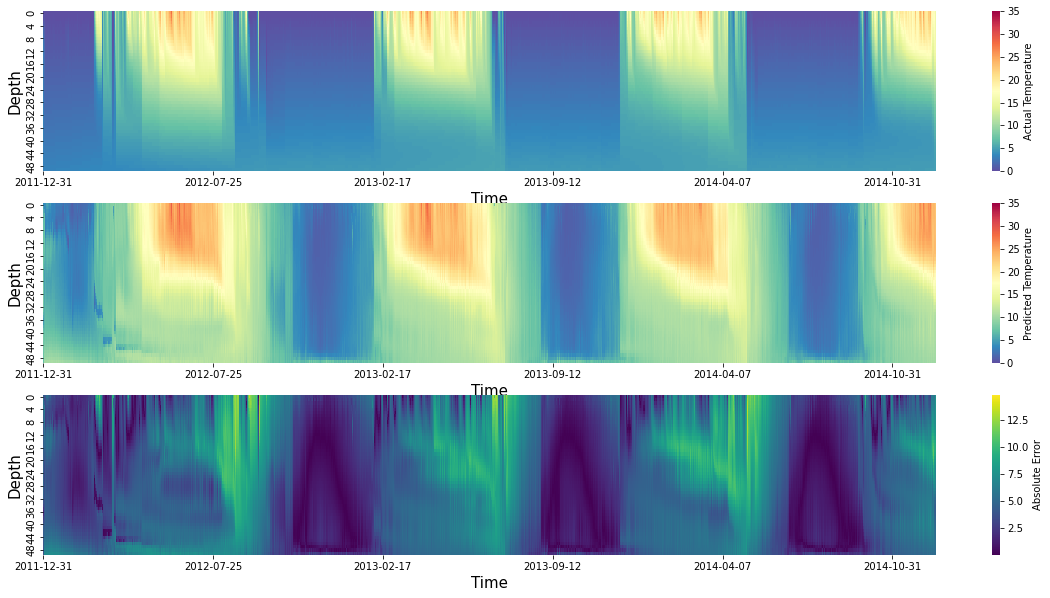

In [39]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

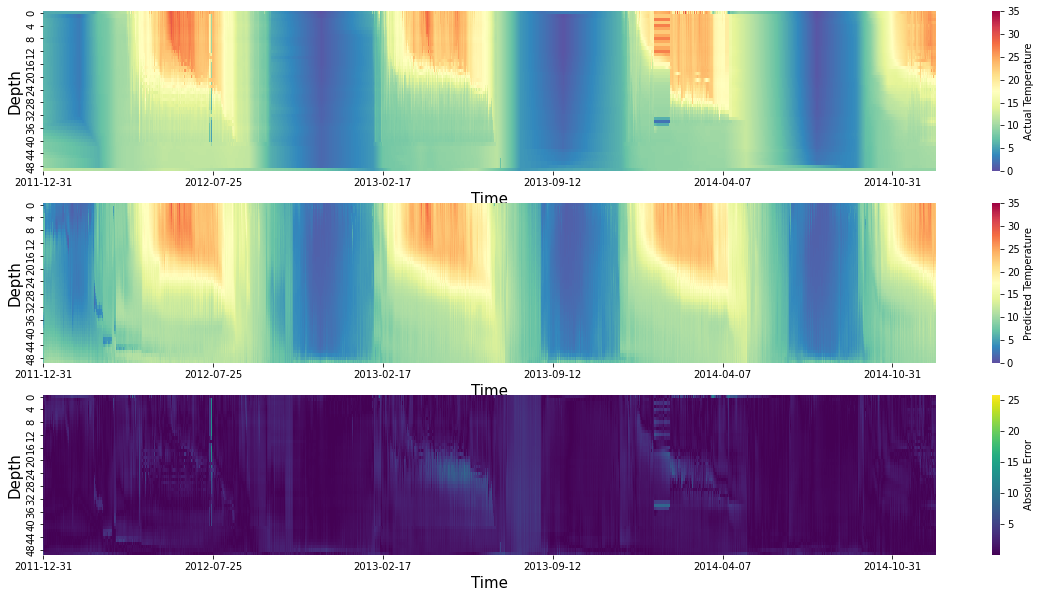

In [40]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [41]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 6.8678927
RMSE of after m0 6.8835044
RMSE of after m0 6.766854
RMSE of after m0 6.6983366
RMSE of after m0 6.707382
RMSE of after m0 6.7359586
RMSE of after m0 6.704999
RMSE of after m0 6.5640655
RMSE of after m0 6.7761483
RMSE of after m0 6.939763
RMSE of after m0 6.817259
RMSE of after m0 6.743653
RMSE of after m0 6.8478284
RMSE of after m0 6.61942
RMSE of after m0 6.4648933
RMSE of after m0 6.6532946
RMSE of after m0 6.855786
RMSE of after m0 7.1106606
RMSE of after m0 7.3058386
RMSE of after m0 7.2699385
RMSE of after m0 7.221885
RMSE of after m0 7.300169
RMSE of after m0 8.023046
RMSE of after m0 8.067625
RMSE of after m0 7.987462
RMSE of after m0 7.9658937
RMSE of after m0 7.9975486
RMSE of after m0 7.858066
RMSE of after m0 7.696177
RMSE of after m0 7.60396
RMSE of after m0 7.6443777
RMSE of after m0 7.5279016
RMSE of after m0 7.3048415
RMSE of after m0 7.146341
RMSE of after m0 6.9817224
RMSE of after m0 6.9521594
RMSE of after m0 7.017843
RMSE of after m0 7.07

RMSE of after m0 3.1066852
RMSE of after m0 3.3524942
RMSE of after m0 3.396226
RMSE of after m0 3.335064
RMSE of after m0 3.4084122
RMSE of after m0 3.8308134
RMSE of after m0 4.01665
RMSE of after m0 3.9682844
RMSE of after m0 4.0961237
RMSE of after m0 4.209438
RMSE of after m0 4.276217
RMSE of after m0 4.3954797
RMSE of after m0 4.517573
RMSE of after m0 4.594801
RMSE of after m0 4.5449967
RMSE of after m0 4.5738087
RMSE of after m0 4.3361773
RMSE of after m0 4.455631
RMSE of after m0 4.5427837
RMSE of after m0 4.6038065
RMSE of after m0 4.594212
RMSE of after m0 4.5700016
RMSE of after m0 4.434711
RMSE of after m0 4.3758845
RMSE of after m0 4.5921674
RMSE of after m0 4.5147095
RMSE of after m0 4.668297
RMSE of after m0 4.591948
RMSE of after m0 4.668298
RMSE of after m0 4.7258234
RMSE of after m0 4.849935
RMSE of after m0 4.9035254
RMSE of after m0 5.034607
RMSE of after m0 5.174114
RMSE of after m0 5.3313274
RMSE of after m0 5.485073
RMSE of after m0 5.477953
RMSE of after m0 5.5

RMSE of after m0 1.0334044
RMSE of after m0 1.1944376
RMSE of after m0 1.3547794
RMSE of after m0 1.3369429
RMSE of after m0 1.2726538
RMSE of after m0 1.3056976
RMSE of after m0 1.2625788
RMSE of after m0 1.1731905
RMSE of after m0 1.200549
RMSE of after m0 1.2449319
RMSE of after m0 1.3313551
RMSE of after m0 1.3630809
RMSE of after m0 1.4553106
RMSE of after m0 1.3413314
RMSE of after m0 1.4641322
RMSE of after m0 1.3332827
RMSE of after m0 1.3364766
RMSE of after m0 1.1729913
RMSE of after m0 1.1258146
RMSE of after m0 1.0752892
RMSE of after m0 1.1081135
RMSE of after m0 1.114328
RMSE of after m0 1.1443588
RMSE of after m0 1.2646222
RMSE of after m0 1.1063907
RMSE of after m0 1.0925914
RMSE of after m0 1.0597936
RMSE of after m0 1.0359046
RMSE of after m0 1.1282858
RMSE of after m0 1.1046569
RMSE of after m0 1.2132585
RMSE of after m0 1.2849269
RMSE of after m0 1.177232
RMSE of after m0 1.1130849
RMSE of after m0 1.1018631
RMSE of after m0 1.1488671
RMSE of after m0 1.1125417
RMSE

RMSE of after m0 7.382234
RMSE of after m0 8.065433
RMSE of after m0 8.273899
RMSE of after m0 8.0294895
RMSE of after m0 8.888177
RMSE of after m0 9.502112
RMSE of after m0 9.405094
RMSE of after m0 9.44245
RMSE of after m0 9.663324
RMSE of after m0 9.382011
RMSE of after m0 9.340197
RMSE of after m0 9.057964
RMSE of after m0 9.085016
RMSE of after m0 9.009927
RMSE of after m0 8.774223
RMSE of after m0 8.577656
RMSE of after m0 8.737619
RMSE of after m0 8.706061
RMSE of after m0 8.588311
RMSE of after m0 8.517669
RMSE of after m0 8.774896
RMSE of after m0 8.57103
RMSE of after m0 8.4059925
RMSE of after m0 8.118169
RMSE of after m0 8.117361
RMSE of after m0 8.038269
RMSE of after m0 7.9333196
RMSE of after m0 7.969746
RMSE of after m0 7.913461
RMSE of after m0 7.8486586
RMSE of after m0 7.6118274
RMSE of after m0 7.770191
RMSE of after m0 7.64361
RMSE of after m0 7.4664783
RMSE of after m0 7.597293
RMSE of after m0 7.570719
RMSE of after m0 7.332113
RMSE of after m0 7.15209
RMSE of af

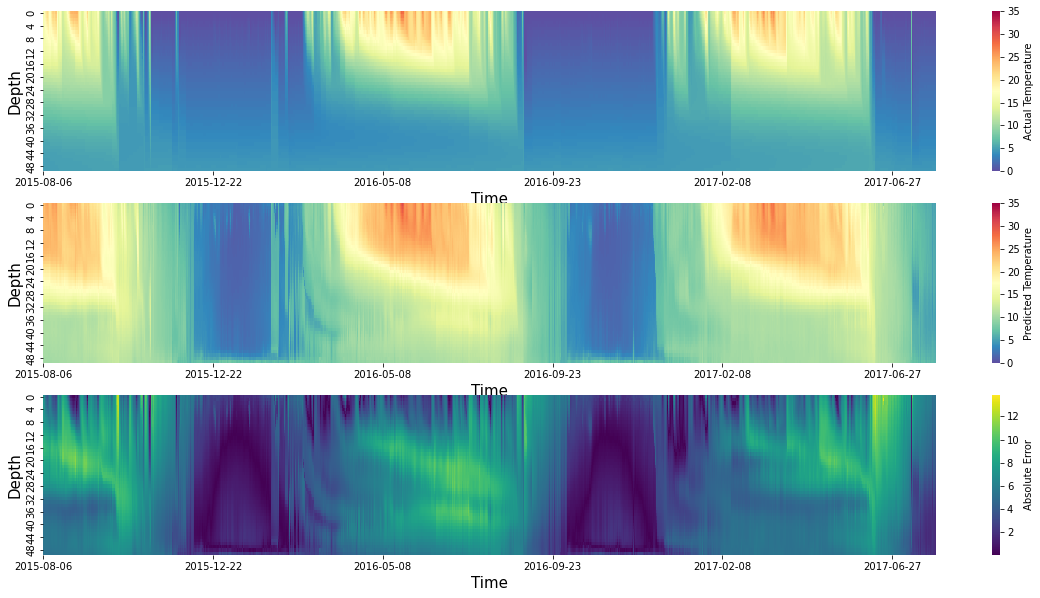

In [42]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

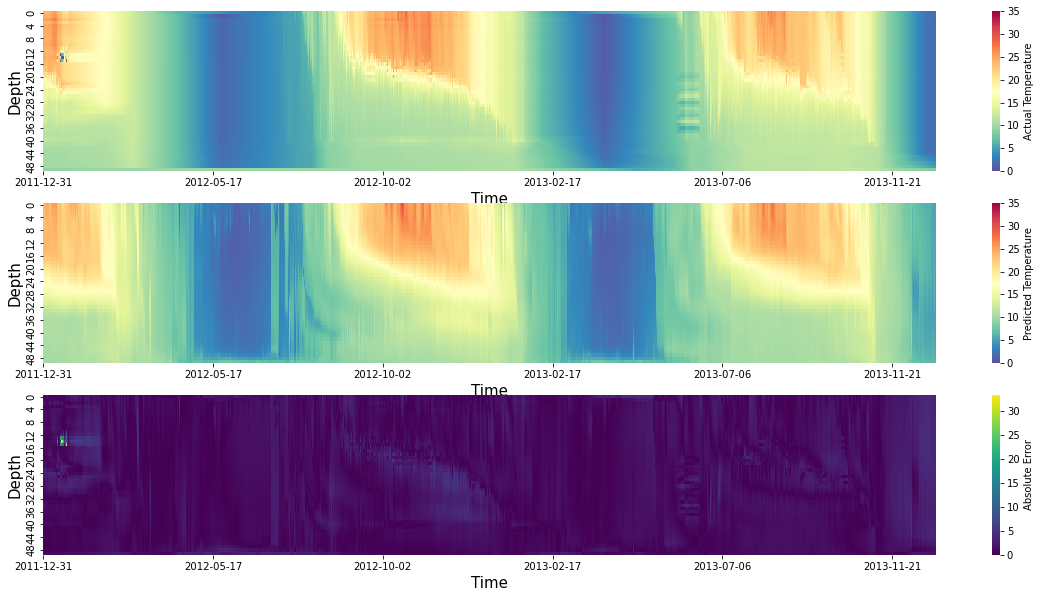

In [43]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

## Mixing Model

## Convection Model

## Ice Model

# Compute Model Similarity after Finetuning

In [44]:
# Freeze all models again and compute finetuned diffusivity values

In [45]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [46]:
PATH = f"./saved_models/directdeep_model_PB_finetuned.pth"
torch.save(direct_model.state_dict(), PATH)